In [1]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
import pickle

In [2]:
style.use('ggplot')

In [3]:
df = quandl.get("WIKI/AAPL")
print(df.head())

             Open   High    Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                          
1980-12-12  28.75  28.87  28.75  28.75  2093900.0          0.0          1.0   
1980-12-15  27.38  27.38  27.25  27.25   785200.0          0.0          1.0   
1980-12-16  25.37  25.37  25.25  25.25   472000.0          0.0          1.0   
1980-12-17  25.87  26.00  25.87  25.87   385900.0          0.0          1.0   
1980-12-18  26.63  26.75  26.63  26.63   327900.0          0.0          1.0   

            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume  
Date                                                                 
1980-12-12   0.422706   0.424470  0.422706    0.422706  117258400.0  
1980-12-15   0.402563   0.402563  0.400652    0.400652   43971200.0  
1980-12-16   0.373010   0.373010  0.371246    0.371246   26432000.0  
1980-12-17   0.380362   0.382273  0.380362    0.380362   21610400.0  
1980-12-18   0.391536   0.

In [4]:
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
print(df.head())

            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume
Date                                                               
1980-12-12   0.422706   0.424470  0.422706    0.422706  117258400.0
1980-12-15   0.402563   0.402563  0.400652    0.400652   43971200.0
1980-12-16   0.373010   0.373010  0.371246    0.371246   26432000.0
1980-12-17   0.380362   0.382273  0.380362    0.380362   21610400.0
1980-12-18   0.391536   0.393300  0.391536    0.391536   18362400.0


In [5]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0

In [6]:
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [7]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

# we're hoping to predict, is actually the future price. As such, our features are actually: 
# current price, high minus low percent, and the percent 
# change volatility. The price that is the label shall be the price at some determined point the future

print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
1980-12-12    0.422706  0.417391    0.000000  117258400.0
1980-12-15    0.400652  0.477064   -0.474799   43971200.0
1980-12-16    0.371246  0.475248   -0.473000   26432000.0
1980-12-17    0.380362  0.502513    0.000000   21610400.0
1980-12-18    0.391536  0.450620    0.000000   18362400.0


In [8]:
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df))) # Round off to the nearest value 
# We need to forecast the stock price - here we need to forecast out the 1 percent of the value
# 0.01 says next 1 day prediction into the future

In [9]:
# The coulumns are our features currently,and adding new column which will predict by shifting to the specified period
df['label'] = df[forecast_col].shift(-forecast_out)

In [10]:
# Regression - Training and Testing
X = np.array(df.drop(['label'], 1)) # All the Features converted to numpy array
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

/Users/Suhas/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [11]:
df.dropna(inplace=True) # Because we are prediction 30 days extra empty values are created in other rows.
# The return here is the training set of features, testing set of features,
# Training set of labels, and testing set of labels

In [12]:
y = np.array(df['label']) # All the Lables

In [13]:
# Which classifier to use - "https://scikit-learn.org/stable/tutorial/machine_learning_map/"
# Using Linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = LinearRegression()
clf.fit(X_train, y_train)
with open('linearregression.pickle','wb') as f: #Saving after the training the classifier
    pickle.dump(clf, f)
confidence = clf.score(X_test, y_test)
print(confidence)

0.975866037851413


In [14]:
pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)
confidence = clf.score(X_test, y_test)
print(confidence)

0.975866037851413


In [15]:
# Using svm
clf = svm.SVR(gamma='auto');
clf.fit(X_train, y_train);
confidence = clf.score(X_test, y_test);
print(confidence);

0.9610441837788057


In [16]:
# Regression - Forecasting and Predicting
forecast_set = clf.predict(X_lately) # Selecting only the last few rows to predict
print(forecast_set)
df['Forecast'] = np.nan # Adding new column to store all the values

[127.43044805 126.02119434 127.18769056 126.9846529  131.51734265
 131.1375348  130.62187403 129.4505409  123.59426422 126.17193809
 124.99758698 127.33575485 127.38983382 102.71324276 125.60043747
 129.04338668 120.88443935 132.21985953 127.75470045 132.31354205
 130.98193306 111.38225145 127.62147471 129.96609606 129.91643359
 128.43363392 125.35193616 126.71369212 128.96800212 128.32195261
 125.55319623 131.3855214  129.71133813 130.59822133 128.46247049
 125.4670982  130.94980489 129.09359545 126.66634314 128.87853118
 128.60656804 126.6318212  125.42997717 125.85481819 122.3061457
 111.37866128 124.33421409 125.49085699 124.47206389 126.7388821
 110.80057999 109.41420862 130.07546245 123.07560102 130.61972701
 134.20754218 133.01481501  72.70960024  84.91120759  36.7553414
 109.92588811  85.94490589  88.29868606  86.91899113 127.42270467
 101.38761934 111.50328605 129.51761142 130.78681805 125.51612582
 130.40845957 124.17512768 116.55735134 123.99199995 123.56642385
  87.29131539

In [17]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [18]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i] 
# Takes all of the first columns, setting them to NaNs, and then the final column is whatever i
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,Forecast
Date,,,,,,
2018-02-05,NaN,NaN,NaN,NaN,NaN,109.084756
2018-02-06,NaN,NaN,NaN,NaN,NaN,125.331619
2018-02-07,NaN,NaN,NaN,NaN,NaN,107.284166
2018-02-08,NaN,NaN,NaN,NaN,NaN,83.110983
2018-02-09,NaN,NaN,NaN,NaN,NaN,68.316423


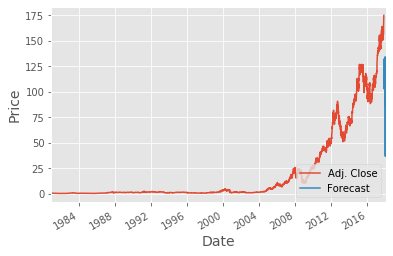

In [19]:
# Visualising the data
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()
# Blue is the predicted value